# Brax Training Speed Benchmark

This notebook benchmarks Brax PPO training across multiple configurations.

It iterates through three `num_envs` sizes (small, medium, large) and three viewer scenarios for each size:
1. **No viewer**: Pure training performance.
2. **Viewer OFF**: Performance with the viewer backend running but rendering disabled.
3. **Viewer ON**: Performance with full, real-time visualization.

## 1. Setup and Imports

In [1]:
import json
import math
import subprocess
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import requests

from brax import envs
from brax.training.agents.ppo import train as ppo
from braxviewer.BraxSender import BraxSender
from braxviewer.WebViewer import WebViewer
from braxviewer.wrapper import ViewerWrapper
from etils import epath

## 2. Configuration

In [2]:
# Basic network and environment configuration
HOST = "0.0.0.0"
BASE_PORT = 8090
ENV_NAME = 'humanoid'
BACKEND = 'positional'

# Define the different sizes for num_envs to be tested.
# These values will be checked for hardware compatibility before execution.
ENV_SIZES = {
    'small': 64,
    'medium': 256,
    'large': 1024
}

print("Configuration defined.")
print(f"Environment: {ENV_NAME}")
print(f"Test Sizes for NUM_ENVS: {ENV_SIZES}")

Configuration defined.
Environment: humanoid
Test Sizes for NUM_ENVS: {'small': 64, 'medium': 256, 'large': 1024}


## 3. Utility Functions

In [3]:
def get_hardware_info():
    """Detects CPU, Memory, and GPU information."""
    info = {}
    info['cpu_count'] = psutil.cpu_count()
    mem = psutil.virtual_memory()
    info['memory_total_gb'] = round(mem.total / (1024**3), 2)
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        gpus = []
        for line in result.stdout.strip().split('\n'):
            name, mem_total = line.split(',')
            gpus.append({'name': name.strip(), 'memory_total_mb': int(mem_total.strip())})
        info['gpus'] = gpus
    except (subprocess.CalledProcessError, FileNotFoundError):
        info['gpus'] = 'N/A'
    return info

def wait_for_rendering_status(host, port, expected_status, timeout=10):
    """Waits for the viewer server's rendering status to match the expected value."""
    start_time = time.time()
    while time.time() - start_time < timeout:
        try:
            url = f"http://{host}:{port}/api/rendering_status"
            response = requests.get(url, timeout=1)
            if response.status_code == 200:
                current_status = response.json().get("rendering_enabled", True)
                if current_status == expected_status:
                    return True
        except requests.exceptions.RequestException:
            pass
        time.sleep(0.5)
    print(f"Timeout waiting for rendering status to become {expected_status}")
    return False

def get_xml_string(env_name):
    """Loads the MJCF model XML for a given environment name."""
    xml_path = epath.resource_path('brax') / f'envs/assets/{env_name}.xml'
    return xml_path.read_text()

print("Utility functions defined.")

Utility functions defined.


## 4. Benchmark Function

In [4]:
def run_benchmark(num_envs: int, base_port: int):
    """Runs the PPO training benchmark for a given number of parallel environments."""
    times = {}
    progress_data = []
    xml_model = get_xml_string(ENV_NAME)
    
    scenarios = [
        (None, "No viewer"),
        (False, "Viewer OFF"), 
        (True, "Viewer ON")
    ]
    
    print(f"\n----- Running Benchmark for NUM_ENVS = {num_envs} -----")
    
    for i, (render, scenario_name) in enumerate(scenarios):
        port = base_port + i
        print(f"  Testing: {scenario_name}")
        
        # The batch_size argument is not passed to the environment creator.
        env = envs.get_environment(env_name=ENV_NAME, backend=BACKEND)
        
        if render is None:
            env_for_training = env
        else:
            viewer = WebViewer(host=HOST, port=port, xml=xml_model, num_envs=num_envs)
            viewer.run()
            sender = BraxSender(host=HOST, port=port, xml=xml_model, num_envs=num_envs)
            sender.start()
            env_for_training = ViewerWrapper(env=env, sender=sender)
            
            if render is False:
                sender.rendering_enabled, viewer.rendering_enabled = False, False
                wait_for_rendering_status(HOST, port, False)
            elif render is True:
                sender.rendering_enabled, viewer.rendering_enabled = True, True
                wait_for_rendering_status(HOST, port, True)

        start_time = time.time()
        
        def progress_fn(step, metrics):
            elapsed_time = time.time() - start_time
            progress_data.append({
                'num_envs': num_envs,
                'scenario': scenario_name,
                'steps': step,
                'time': elapsed_time
            })

        ppo.train(
            environment=env_for_training,
            num_envs=num_envs, # The number of parallel envs is passed to the trainer.
            num_timesteps=50_000,
            num_evals=10,
            episode_length=1000,
            normalize_observations=True,
            action_repeat=1,
            unroll_length=10,
            num_minibatches=32,
            num_updates_per_batch=8,
            discounting=0.97,
            learning_rate=3e-4,
            entropy_cost=1e-3,
            seed=1,
            progress_fn=progress_fn
        )
        end_time = time.time()

        if render is not None:
            sender.stop()
            viewer.stop()

        times[scenario_name] = end_time - start_time
        print(f"    Total Time: {times[scenario_name]:.2f}s")
    
    return times, pd.DataFrame(progress_data)

print("Benchmark function defined.")

Benchmark function defined.


## 5. Execute All Benchmarks

In [5]:
all_results = []
all_progress_dfs = []
device_count = jax.device_count()
print(f"Detected {device_count} JAX device(s). Preparing runs...")

for size_name, num_envs_val in ENV_SIZES.items():
    # Ensure num_envs is a non-zero multiple of the device count for compatibility.
    compatible_num_envs = num_envs_val
    if num_envs_val % device_count != 0:
        compatible_num_envs = (num_envs_val // device_count) * device_count
        print(f"Adjusting '{size_name}' size from {num_envs_val} to {compatible_num_envs} for device compatibility.")
        
    if compatible_num_envs == 0:
         print(f"Skipping '{size_name}' size ({num_envs_val}) as it's too small for {device_count} device(s).")
         continue
    
    # Use a different port range for each size to avoid conflicts.
    port_offset = list(ENV_SIZES.keys()).index(size_name) * 10
    results, progress_df = run_benchmark(
        num_envs=compatible_num_envs, 
        base_port=BASE_PORT + port_offset
    )
    
    all_results.append({
        'size_name': size_name,
        'num_envs': compatible_num_envs,
        'benchmark_results': results
    })
    all_progress_dfs.append(progress_df)

# Combine all progress data into a single DataFrame for easier plotting and saving.
if all_progress_dfs:
    final_progress_df = pd.concat(all_progress_dfs, ignore_index=True)
else:
    final_progress_df = pd.DataFrame()

print("\nAll benchmark runs complete.")

Detected 1 JAX device(s). Preparing runs...

----- Running Benchmark for NUM_ENVS = 64 -----
  Testing: No viewer


/workspace/brax_training_viewer/brax/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-08-01 03:48:10.592144: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 03:48:22.930464: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set i

    Total Time: 94.49s
  Testing: Viewer OFF


2025-08-01 03:49:51,571 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8091
2025-08-01 03:49:51,575 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8091 (Press CTRL+C to quit)
2025-08-01 03:49:53,578 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 03:49:53,580 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:40826 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     127.0.0.1:40822 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
INFO:     connection open
2025-08-01 03:51:00,361 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 03:51:00,367 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 03:51:00,431 - brax.sender - INFO - Auto-calculated grid_dims: 

    Total Time: 66.29s
  Testing: Viewer ON


2025-08-01 03:51:03,493 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8092
2025-08-01 03:51:03,496 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8092 (Press CTRL+C to quit)
2025-08-01 03:51:05,499 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 03:51:05,500 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:33302 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
INFO:     127.0.0.1:33322 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
2025-08-01 03:57:53,867 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 03:57:53,873 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed


    Total Time: 408.23s

----- Running Benchmark for NUM_ENVS = 256 -----
  Testing: No viewer


2025-08-01 03:58:29.920016: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 03:58:29.920055: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 03:58:29.920062: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 03:58:29.920068: W external/xla/xla/service/gpu/au

    Total Time: 75.04s
  Testing: Viewer OFF


2025-08-01 03:59:37,650 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8101
2025-08-01 03:59:37,654 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8101 (Press CTRL+C to quit)
2025-08-01 03:59:39,657 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 03:59:39,659 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:49314 - "WebSocket /ws/frame?is_streamer=true" [accepted]
2025-08-01 03:59:39,664 - brax.sender - INFO - Streamer connected to frame endpoint.
INFO:     connection open
INFO:     127.0.0.1:49332 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
2025-08-01 04:00:44,592 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 04:00:44,598 - brax.sender - WARNING - Streamer disconnected.
INFO:     connect

    Total Time: 64.61s
  Testing: Viewer ON


2025-08-01 04:01:07,375 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8102
2025-08-01 04:01:07,377 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8102 (Press CTRL+C to quit)
2025-08-01 04:01:09,380 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 04:01:09,381 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:55606 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
INFO:     127.0.0.1:55652 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
2025-08-01 04:07:54,225 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 04:07:54,232 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed


    Total Time: 404.58s

----- Running Benchmark for NUM_ENVS = 1024 -----
  Testing: No viewer


2025-08-01 04:08:28.991482: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 04:08:28.991521: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 04:08:28.991527: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-01 04:08:28.991547: W external/xla/xla/service/gpu/au

    Total Time: 68.93s
  Testing: Viewer OFF


2025-08-01 04:13:50,976 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8111
2025-08-01 04:13:50,979 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8111 (Press CTRL+C to quit)
2025-08-01 04:13:52,982 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 04:13:52,983 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:35522 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
INFO:     127.0.0.1:35534 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
2025-08-01 04:14:57,573 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 04:14:57,578 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 04:14:57,712 - brax.sender - INFO - Auto-calculated grid_dims: 

    Total Time: 63.58s
  Testing: Viewer ON


2025-08-01 04:19:41,009 - brax.sender - INFO - Brax Viewer starting on http://0.0.0.0:8112
2025-08-01 04:19:41,013 - brax.sender - INFO - Server log level: warning
INFO:     Started server process [12807]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8112 (Press CTRL+C to quit)
2025-08-01 04:19:43,016 - brax.sender - INFO - Brax Sender streamer initialized.
2025-08-01 04:19:43,018 - brax.sender - INFO - Application log level: info
INFO:     127.0.0.1:34344 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
INFO:     127.0.0.1:34362 - "WebSocket /ws/frame?is_streamer=true" [accepted]
INFO:     connection open
2025-08-01 04:26:34,272 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed
2025-08-01 04:26:34,277 - brax.sender - WARNING - Streamer disconnected.
INFO:     connection closed


    Total Time: 410.25s

All benchmark runs complete.


## 6. Save All Results

In [ ]:
if not all_results:
    print("No results to save.")
else:
    hardware_info = get_hardware_info()
    try:
        gpu_name = hardware_info['gpus'][0]['name'].replace(' ', '_')
    except (TypeError, IndexError, KeyError):
        gpu_name = "CPU"

    # Save a single JSON report containing hardware info and all run results.
    final_report = {
        'hardware_info': hardware_info,
        'all_runs': all_results
    }
    report_filename = f"report_{ENV_NAME}_{gpu_name}.json"
    with open(report_filename, 'w') as f:
        json.dump(final_report, f, indent=4)
    print(f"Saved consolidated report to: {report_filename}")

    # Save a single CSV with all detailed progress data.
    progress_filename = f"progress_{ENV_NAME}_{gpu_name}.csv"
    final_progress_df.to_csv(progress_filename, index=False)
    print(f"Saved consolidated progress data to: {progress_filename}")

Saved consolidated report to: report_humanoid_NVIDIA_GeForce_RTX_5090.json
Saved consolidated progress data to: progress_humanoid_NVIDIA_GeForce_RTX_5090.csv


## 7. Load and Visualize All Historical Results

This final cell is self-contained. It scans the directory for all report and progress files, then generates a consolidated plot comparing all historical runs from any device.

Loaded data from 2 device(s)/run(s).

Saved consolidated comparison plot to: consolidated_benchmark_comparison.png


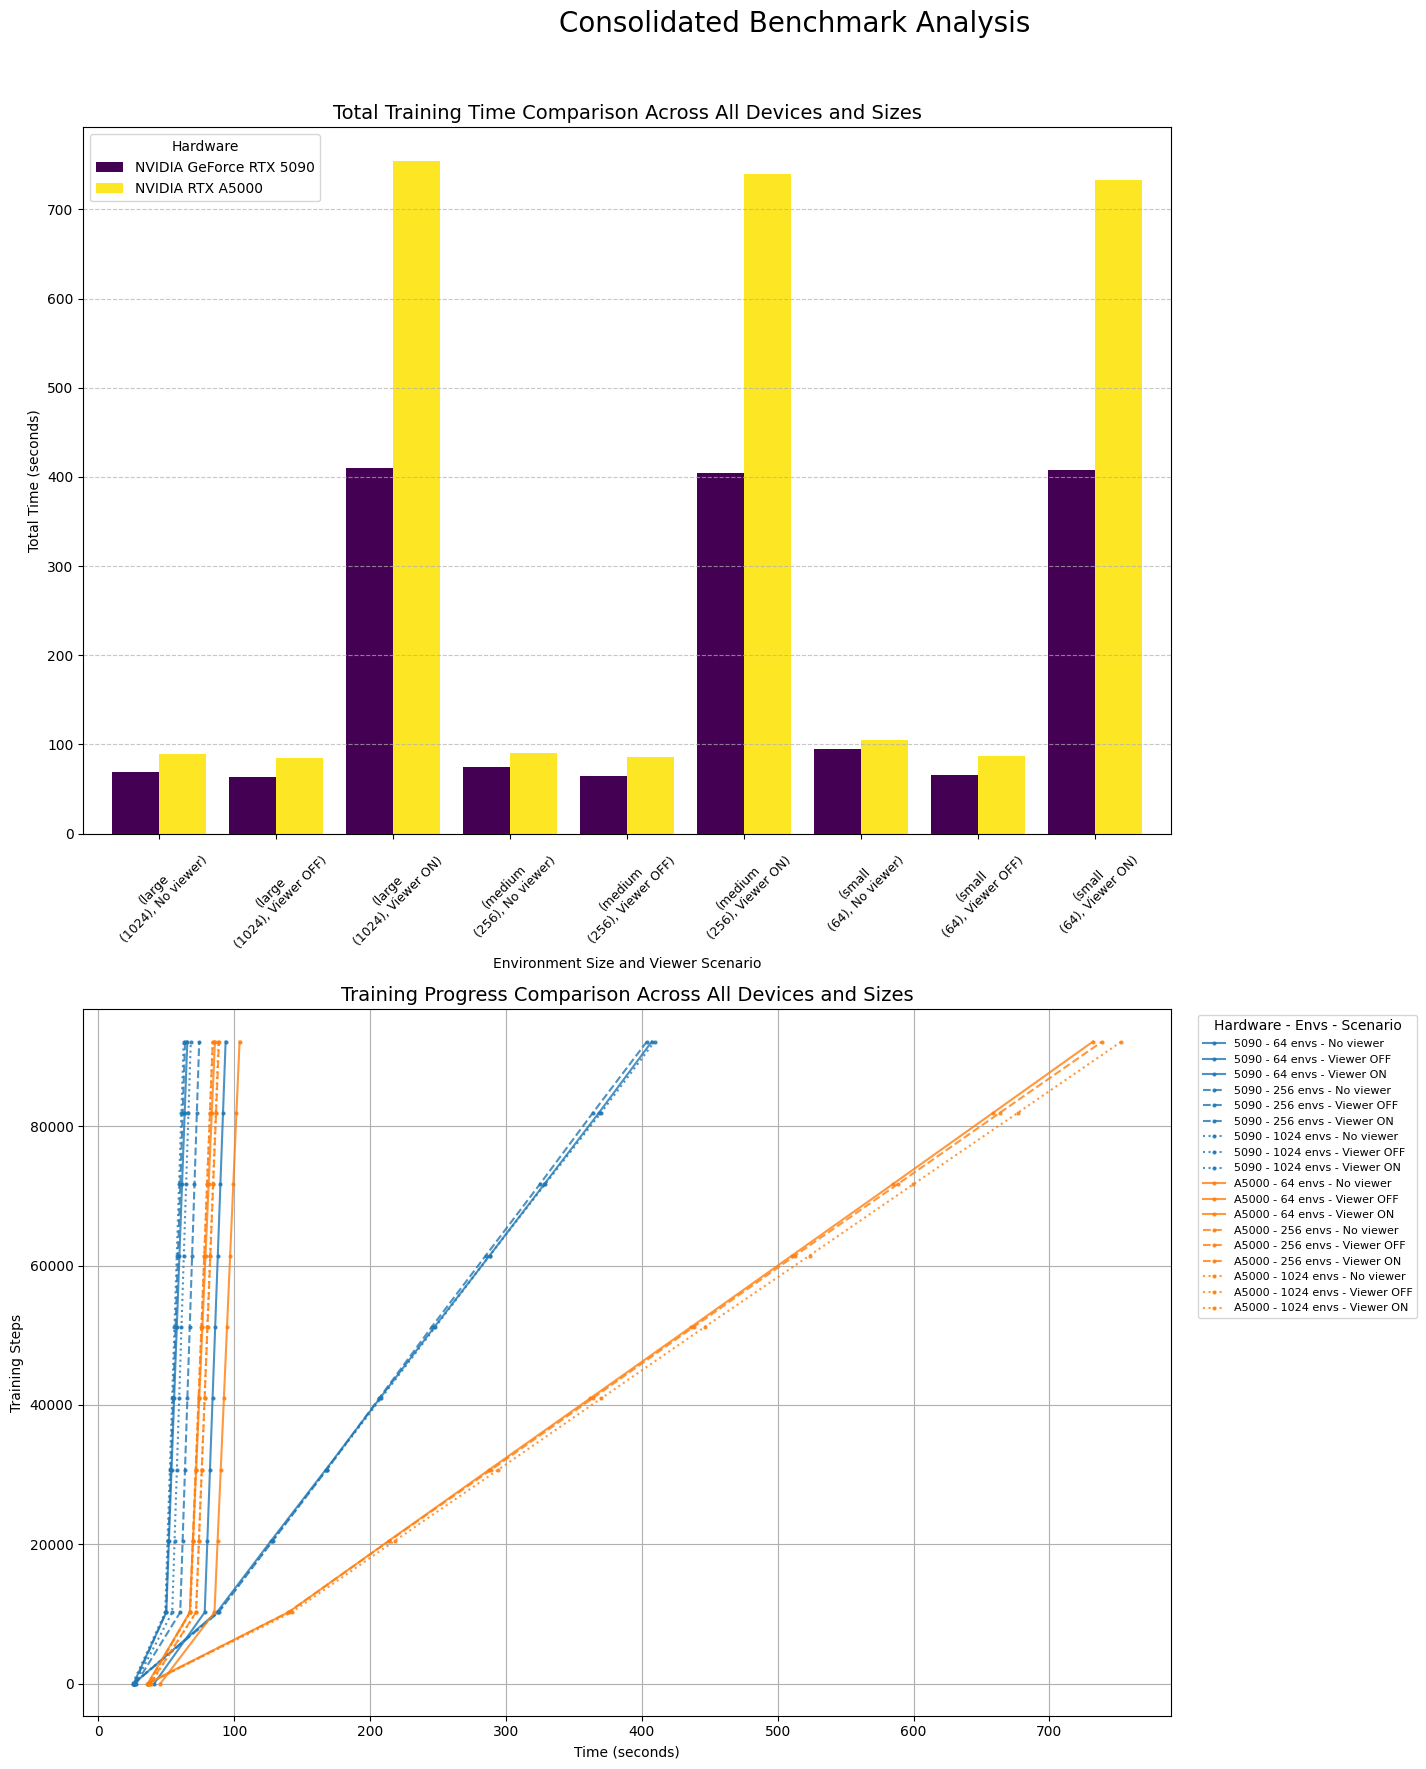

In [ ]:
import glob

report_files = glob.glob(f"report_{ENV_NAME}_*.json")
progress_files = glob.glob(f"progress_{ENV_NAME}_*.csv")

if not report_files:
    print("No report files found. Please run the benchmark first.")
else:
    # Load all JSON reports into a structured DataFrame for plotting.
    plot_data = []
    for file_path in report_files:
        with open(file_path, 'r') as f:
            report = json.load(f)
            try:
                gpu_name = report['hardware_info']['gpus'][0]['name']
            except (TypeError, IndexError, KeyError):
                gpu_name = 'CPU'
            
            for run in report.get('all_runs', []):
                for scenario, time in run['benchmark_results'].items():
                    plot_data.append({
                        'gpu': gpu_name,
                        'size': f"{run['size_name']}\n({run['num_envs']})",
                        'scenario': scenario,
                        'time': time
                    })
    plot_df = pd.DataFrame(plot_data)

    # Load and concatenate all progress CSVs.
    df_list = []
    for file_path in progress_files:
        try:
            gpu_name_from_file = file_path.split('_')[-1].replace('.csv', '')
            df = pd.read_csv(file_path)
            df['gpu_name'] = gpu_name_from_file.replace('_', ' ')
            df_list.append(df)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")
    master_progress_df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

    print(f"Loaded data from {len(report_files)} device(s)/run(s).")

    # --- Visualize Consolidated Data ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18), gridspec_kw={'height_ratios': [1, 1]})
    fig.suptitle('Consolidated Benchmark Analysis', fontsize=20)
    
    # Plot 1: Grouped Bar Chart for Total Runtimes
    if not plot_df.empty:
        pivot_df = plot_df.pivot_table(index=['size', 'scenario'], columns='gpu', values='time')
        pivot_df.plot(kind='bar', ax=ax1, width=0.8, colormap='viridis')
        ax1.set_title(f'Total Training Time Comparison Across All Devices and Sizes', fontsize=14)
        ax1.set_ylabel('Total Time (seconds)')
        ax1.set_xlabel('Environment Size and Viewer Scenario')
        ax1.tick_params(axis='x', rotation=45, labelsize=9)
        ax1.legend(title='Hardware')
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Training Progress Curves
    if not master_progress_df.empty:
        styles = ['-', '--', ':', '-.']
        colors = plt.cm.tab10.colors
        gpu_map = {gpu: colors[i % len(colors)] for i, gpu in enumerate(master_progress_df['gpu_name'].unique())}
        size_map = {size: styles[i % len(styles)] for i, size in enumerate(sorted(master_progress_df['num_envs'].unique()))}
        
        for (gpu, num_envs, scenario), group in master_progress_df.groupby(['gpu_name', 'num_envs', 'scenario']):
            label = f'{gpu} - {num_envs} envs - {scenario}'
            linestyle = size_map[num_envs]
            color = gpu_map[gpu]
            ax2.plot(group['time'], group['steps'], label=label, linestyle=linestyle, color=color, marker='.', markersize=4, alpha=0.8)

        ax2.set_title('Training Progress Comparison Across All Devices and Sizes', fontsize=14)
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Training Steps')
        ax2.legend(title='Hardware - Envs - Scenario', fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')
        ax2.grid(True)

    # Final adjustments and saving
    fig.tight_layout(rect=[0, 0, 0.9, 0.96])
    consolidated_plot_filename = 'consolidated_benchmark_comparison.png'
    plt.savefig(consolidated_plot_filename)
    print(f"\nSaved consolidated comparison plot to: {consolidated_plot_filename}")
    plt.show()